In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
from codes import utils, hf, kwant_examples
from tqdm import tqdm

Now we show the interface with `kwant`. We start by using `kwant` to build two tight-binding systems with translational symmetry:
* graphene;
* a dummy `kwant.Builder` that encodes the interaction matrix.
See [`kwant_examples`](./codes/kwant_examples.py) to verify how these two steps are done.

In [2]:
# Create translationally-invariant `kwant.Builder`
graphene_builder, int_builder = kwant_examples.graphene_extended_hubbard()

We then use `utils.builder2tb_model` to parse the `kwant.Builder` to a `tb_model` that we will use in the self-consistent calculations.

In [3]:
tb_model = utils.builder2tb_model(graphene_builder)

Note that the self-consistent loop is performed on a coarse k-point grid, and thus not necessarily appropriate to compute observables. We thus use `utils.kgrid_hamiltonian` to evaluate the Hamiltonian on a denser k-point grid and compute the gap.

In [4]:
def compute_gap(
    tb_model,
    int_model,
    nk,
    nk_dense,
    U,
    filling=2,
    guess=None,
):
    scale = np.max(np.array([*tb_model.values()]))
    # Generate guess on the same grid
    if guess is None:
        guess = utils.generate_guess(nk, tb_model, int_model, scale=scale)
    else:
        guess += utils.generate_guess(
            nk, tb_model, int_model, scale=scale
        )

    # Find groundstate Hamiltonian on the same grid
    mf_model, mf = hf.find_groundstate_ham(
        tb_model=tb_model,
        int_model=int_model,
        filling=filling,
        nk=nk,
        guess=guess,
        return_mf=True,
    )
    # Compute groundstate Hamiltonian on a dense grid
    scf_ham = utils.kgrid_hamiltonian(nk_dense, mf_model)
    # Diagonalize groundstate Hamiltonian
    vals, vecs = np.linalg.eigh(scf_ham)
    # Extract dense-grid Fermi energy
    E_F = utils.get_fermi_energy(vals, filling)
    gap = utils.calc_gap(vals, E_F)
    return gap, mf

Finally, we also parse `int_builder` with the wanted interaction strength. Note that we pass a `params` dictionary to evaluate the Hamiltonian with `kwant`.

In [5]:
def compute_phase_diagram(Us, Vs, nk, nk_dense):
    gap = []
    for U in tqdm(Us):
        guess = None
        gap_U = []
        for V in Vs:
            params = dict(U=U, V=V)
            _gap, guess = compute_gap(
                tb_model=tb_model,
                int_model=utils.builder2tb_model(int_builder, params),
                nk=nk,
                nk_dense=nk_dense,
                guess=guess, U=U
            )
            gap_U.append(_gap)
        gap.append(gap_U)
    return np.asarray(gap, dtype=float)

**Warning:** this phase diagram calculation takes about one hour.

In [6]:
# Generate dense-grid k-points
# Interaction strengths
nk=15
nk_dense=30
Us = np.linspace(0, 3, 20, endpoint=True)
Vs = np.linspace(0, 1.5, 20, endpoint=True)
gap = compute_phase_diagram(Us, Vs, nk=nk, nk_dense=nk_dense)

100%|██████████| 20/20 [53:16<00:00, 159.83s/it]


In [7]:
import xarray as xr
gap_da = xr.DataArray(data=gap, coords=dict(Us=Us, Vs=Vs))

We note that the gap openings coincide with the phase transitions from gapless to charge density wave or antiferromagnetic groundstates as predicted in [arXiv:1204.4531](https://arxiv.org/abs/1204.4531). 

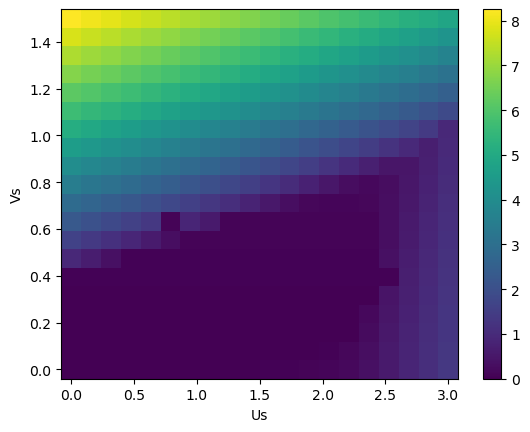

In [8]:
gap_da.plot(x='Us', y='Vs')

In [9]:
gap_da.to_netcdf('./data/graphene_example.nc')